# Genshin Impact Reviews Analysis
## 3. Sentiment Analysis & Classification (Part 2) - Optimising LSTM
In this notebook, I will seek to optimise the results from the LSTM model by tweaking different parameters.

# Import Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(11)
tf.random.set_seed(11)

import pickle

In [2]:
df = pd.read_pickle('data/final_df.p')
df.head()

,content,score,date,thumbsUp,source,text,length,update
0,"The graphics are gorgeous, the gameplay is inc...",5,2020-12-11 13:55:29,881.0,google_play_store,"[the, graphics, are, gorgeous, the, gameplay, ...",84,1.1.2
1,"If you love free world RPG, then this is it! T...",5,2020-12-16 18:10:47,48.0,google_play_store,"[if, you, love, free, world, rpg, then, this, ...",94,1.1.2
2,I absolutely love the game! No complaints besi...,5,2020-12-16 00:18:43,185.0,google_play_store,"[i, absolutely, love, the, game, no, complaint...",75,1.1.2
3,Great game. Regardless of ripoff issues and su...,4,2020-12-16 12:46:11,1.0,google_play_store,"[great, game, regardless, of, ripoff, issues, ...",88,1.1.2
4,Amazing graphics and gameplay although a lot o...,5,2020-12-10 22:51:08,186.0,google_play_store,"[amazing, graphics, and, gameplay, although, a...",86,1.1.2


In [3]:
df.shape

(88199, 8)

# Optimising LSTM Model

## Define Common Function

In [4]:
def find_class_weight(target_df):
    
    score_count = target_df.value_counts(sort=False)
    score_count_max = score_count.max()

    counter = 0
    score_class_weight = dict()

    for _, value in score_count.items():

        score_class_weight[counter] = score_count_max/value
        counter += 1

    return score_class_weight

In [5]:
def plot_nn_history(history, metrics = 'accuracy'):
    
    fig, ax = plt.subplots(ncols = 2, figsize = (16, 5))

    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Val Loss')
    ax[0].legend()

    ax[1].plot(history.history[metrics], label=f'Train {metrics.capitalize()}')
    ax[1].plot(history.history[f'val_{metrics}'], label=f'Val {metrics.capitalize()}')
    ax[1].legend()

    plt.show()

In [6]:
def plot_confusion_matrix(y_test, pred, n_labels = 2):
    
    cm = confusion_matrix(y_test, pred)
    ticks = range(1, n_labels+1)

    plt.figure(figsize = (7, 5.5))
    sns.heatmap(cm, annot = True, fmt = '.5g', cmap = 'coolwarm', xticklabels = ticks, yticklabels = ticks)
    plt.title('Confusion Matrix', fontsize = 15)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(f"Accuracy: {accuracy_score(y_test, pred):.4g}")
    print(f"F1-Score: {f1_score(y_test, pred):.4g}")

In [7]:
def nn_metrics(model, text_seq, y_test, n_labels):
    
    pred_array = model.predict(text_seq)

    pred = [np.where(array == array.max())[0][0]+1 for array in pred_array]
    
    plot_confusion_matrix(y_test, pred, n_labels)

## Data Preprocessing

I will work on the same sample dataset that was used in the previous notebook for consistency.

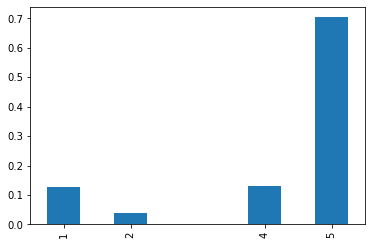

In [8]:
model_df = df.sample(frac = 0.4, random_state = 11)
model_df = model_df[model_df['score'] != 3].copy()

model_df['score'].value_counts(normalize = True, sort = False).plot(kind='bar');

In [9]:
def positive_negative(score):
    if score <= 3:
        return 1
    if score > 3:
        return 2
    
model_df['pn'] = model_df['score'].apply(lambda x: positive_negative(x))

In [10]:
X = model_df['content'].copy()
y = model_df[['pn']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 11, stratify = y)

In [11]:
vocab_size = 7000

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)

max_len = 125

train_padded_sequence = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_len)
test_padded_sequence = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = max_len)

In [12]:
enc = OneHotEncoder()
scores_cat = enc.fit_transform(y_train[['pn']]).toarray()

classweight = find_class_weight(y_train[['pn']])

## Benchmark Model 

This is the benchmark model before optimising hyperparameters.

**Two classes:**
1. Positive (Ratings of 4 and 5)
2. Negative (Ratings of 1 and 2)

Reviews with ratings of 3 are excluded.

In [13]:
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, scores_cat, validation_split=0.2, 
                    epochs=10, batch_size=32, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/10
619/619 [==============================] - 49s 79ms/step - loss: 0.7578 - accuracy: 0.7801 - val_loss: 0.3720 - val_accuracy: 0.8545
Epoch 2/10
619/619 [==============================] - 48s 78ms/step - loss: 0.5218 - accuracy: 0.8645 - val_loss: 0.2719 - val_accuracy: 0.8798
Epoch 3/10
619/619 [==============================] - 49s 79ms/step - loss: 0.4447 - accuracy: 0.8846 - val_loss: 0.3209 - val_accuracy: 0.8620
Epoch 4/10
619/619 [==============================] - 46s 75ms/step - loss: 0.3966 - accuracy: 0.8974 - val_loss: 0.2828 - val_accuracy: 0.8848
Epoch 5/10
619/619 [==============================] - 47s 76ms/step - loss: 0.3612 - accuracy: 0.9078 - val_loss: 0.3038 - val_accuracy: 0.8790


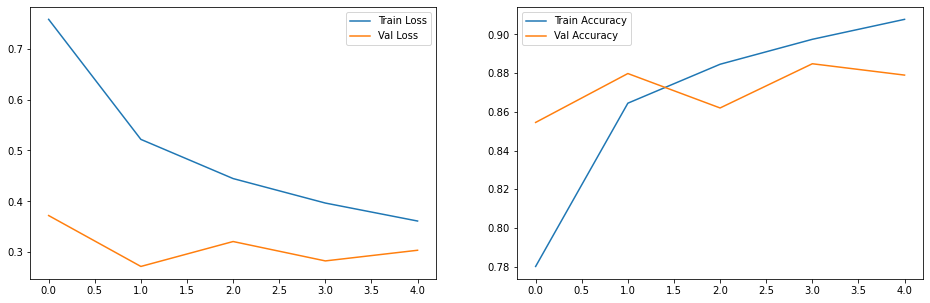

In [14]:
plot_nn_history(history)

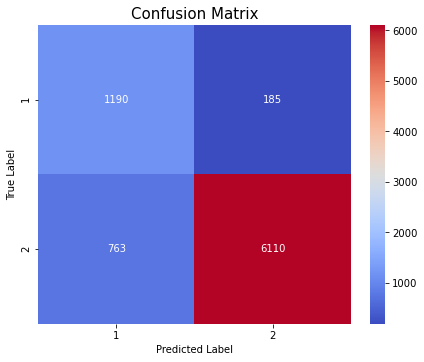

Accuracy: 0.8851
F1-Score: 0.7151


In [15]:
nn_metrics(model, test_padded_sequence, y_test['pn'], 2)

## Optimising Learning Rates
In this section, I will try different learning rates (both higher and lower than the default) to see if it makes any changes to the result.

I will keep to using Adam optimizer as it is one of the best optimizer for NLP classification.

### Learning Rate = 1e-4

In [16]:
embedding_vector_length = 32
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, scores_cat, validation_split=0.2, 
                    epochs=15, batch_size=32, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/15
619/619 [==============================] - 46s 74ms/step - loss: 1.1054 - accuracy: 0.6636 - val_loss: 0.6267 - val_accuracy: 0.6246
Epoch 2/15
619/619 [==============================] - 46s 74ms/step - loss: 0.9159 - accuracy: 0.7284 - val_loss: 0.4544 - val_accuracy: 0.8202
Epoch 3/15
619/619 [==============================] - 46s 74ms/step - loss: 0.6812 - accuracy: 0.8276 - val_loss: 0.3985 - val_accuracy: 0.8414
Epoch 4/15
619/619 [==============================] - 46s 74ms/step - loss: 0.5906 - accuracy: 0.8492 - val_loss: 0.3304 - val_accuracy: 0.8687
Epoch 5/15
619/619 [==============================] - 46s 74ms/step - loss: 0.5573 - accuracy: 0.8601 - val_loss: 0.3360 - val_accuracy: 0.8681
Epoch 6/15
619/619 [==============================] - 47s 75ms/step - loss: 0.5197 - accuracy: 0.8693 - val_loss: 0.3149 - val_accuracy: 0.8753
Epoch 7/15
619/619 [==============================] - 46s 74ms/step - loss: 0.4988 - accuracy: 0.8749 - val_loss: 0.3286 - val_accuracy:

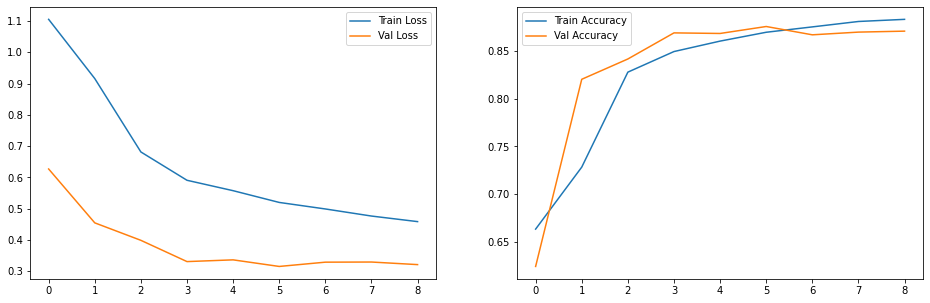

In [17]:
plot_nn_history(history)

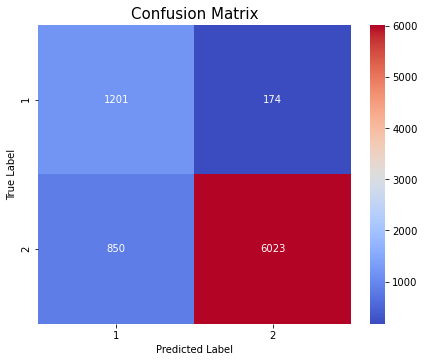

Accuracy: 0.8758
F1-Score: 0.7011


In [18]:
nn_metrics(model, test_padded_sequence, y_test['pn'], 2)

### Learning Rate = 2e-3

In [19]:
embedding_vector_length = 32
opt = tf.keras.optimizers.Adam(learning_rate=0.002)

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, scores_cat, validation_split=0.2, 
                    epochs=15, batch_size=32, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/15
619/619 [==============================] - 45s 73ms/step - loss: 0.7368 - accuracy: 0.7860 - val_loss: 0.3888 - val_accuracy: 0.8359
Epoch 2/15
619/619 [==============================] - 45s 72ms/step - loss: 0.5044 - accuracy: 0.8688 - val_loss: 0.3101 - val_accuracy: 0.8733
Epoch 3/15
619/619 [==============================] - 45s 72ms/step - loss: 0.4319 - accuracy: 0.8908 - val_loss: 0.2898 - val_accuracy: 0.8820
Epoch 4/15
619/619 [==============================] - 45s 73ms/step - loss: 0.3746 - accuracy: 0.9052 - val_loss: 0.2906 - val_accuracy: 0.8767
Epoch 5/15
619/619 [==============================] - 45s 73ms/step - loss: 0.3373 - accuracy: 0.9168 - val_loss: 0.2934 - val_accuracy: 0.8824
Epoch 6/15
619/619 [==============================] - 46s 74ms/step - loss: 0.3040 - accuracy: 0.9245 - val_loss: 0.2732 - val_accuracy: 0.8901
Epoch 7/15
619/619 [==============================] - 45s 74ms/step - loss: 0.2921 - accuracy: 0.9251 - val_loss: 0.3136 - val_accuracy:

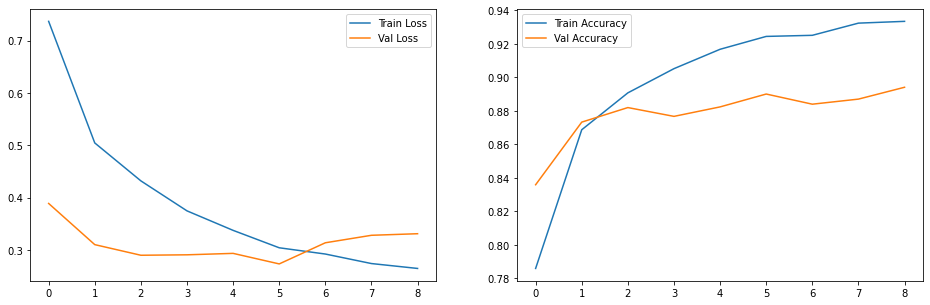

In [20]:
plot_nn_history(history)

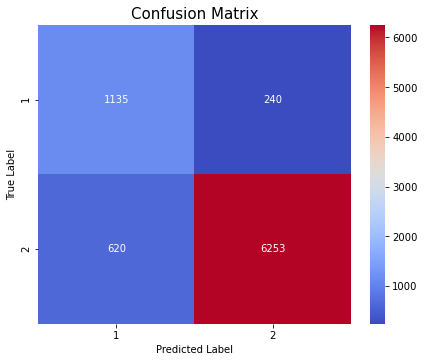

Accuracy: 0.8957
F1-Score: 0.7252


In [21]:
nn_metrics(model, test_padded_sequence, y_test['pn'], 2)

### Learning Rate = 5e-3

In [22]:
embedding_vector_length = 32
opt = tf.keras.optimizers.Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, scores_cat, validation_split=0.2, 
                    epochs=15, batch_size=32, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/15
619/619 [==============================] - 46s 74ms/step - loss: 0.7252 - accuracy: 0.7989 - val_loss: 0.2902 - val_accuracy: 0.8792
Epoch 2/15
619/619 [==============================] - 46s 74ms/step - loss: 0.4869 - accuracy: 0.8766 - val_loss: 0.2926 - val_accuracy: 0.8727
Epoch 3/15
619/619 [==============================] - 46s 74ms/step - loss: 0.4094 - accuracy: 0.8958 - val_loss: 0.2746 - val_accuracy: 0.8933
Epoch 4/15
619/619 [==============================] - 48s 77ms/step - loss: 0.3595 - accuracy: 0.9050 - val_loss: 0.2803 - val_accuracy: 0.8842
Epoch 5/15
619/619 [==============================] - 47s 76ms/step - loss: 0.3165 - accuracy: 0.9184 - val_loss: 0.3248 - val_accuracy: 0.8788
Epoch 6/15
619/619 [==============================] - 46s 75ms/step - loss: 0.3015 - accuracy: 0.9242 - val_loss: 0.3029 - val_accuracy: 0.8931


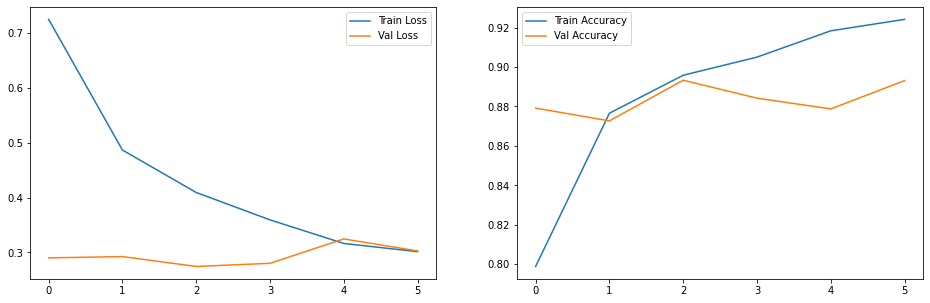

In [23]:
plot_nn_history(history)

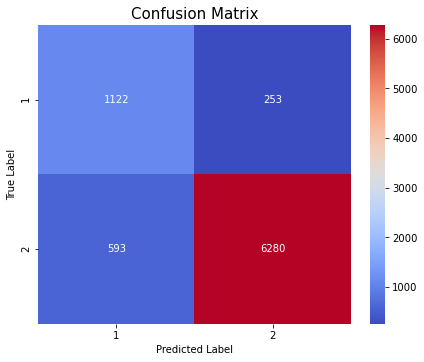

Accuracy: 0.8974
F1-Score: 0.7262


In [24]:
nn_metrics(model, test_padded_sequence, y_test['pn'], 2)

## Optimising Dropout
From all the previous validation results, there seems to be a bit of overfitting. I will test the effect of increasing the dropout rate.

In [25]:
embedding_vector_length = 32
opt = tf.keras.optimizers.Adam(learning_rate=0.002)

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, scores_cat, validation_split=0.2, 
                    epochs=15, batch_size=32, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/15
619/619 [==============================] - 46s 74ms/step - loss: 0.7912 - accuracy: 0.7706 - val_loss: 0.4557 - val_accuracy: 0.8147
Epoch 2/15
619/619 [==============================] - 46s 74ms/step - loss: 0.5853 - accuracy: 0.8499 - val_loss: 0.3053 - val_accuracy: 0.8691
Epoch 3/15
619/619 [==============================] - 47s 76ms/step - loss: 0.4989 - accuracy: 0.8706 - val_loss: 0.2976 - val_accuracy: 0.8699
Epoch 4/15
619/619 [==============================] - 46s 75ms/step - loss: 0.4428 - accuracy: 0.8850 - val_loss: 0.2618 - val_accuracy: 0.8858
Epoch 5/15
619/619 [==============================] - 47s 76ms/step - loss: 0.3973 - accuracy: 0.8999 - val_loss: 0.2922 - val_accuracy: 0.8834
Epoch 6/15
619/619 [==============================] - 51s 82ms/step - loss: 0.3730 - accuracy: 0.9071 - val_loss: 0.2875 - val_accuracy: 0.8974
Epoch 7/15
619/619 [==============================] - 48s 77ms/step - loss: 0.3534 - accuracy: 0.9099 - val_loss: 0.3017 - val_accuracy:

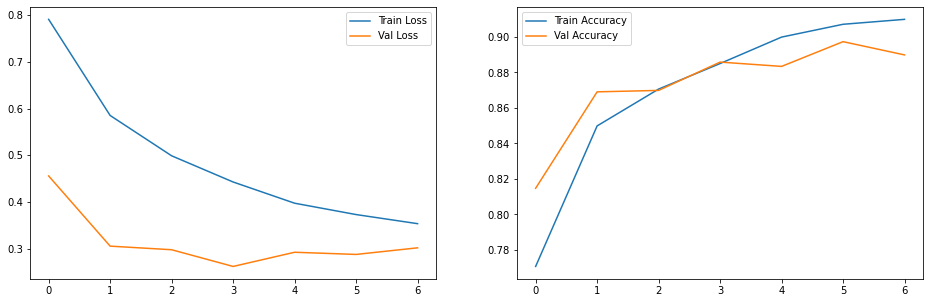

In [26]:
plot_nn_history(history)

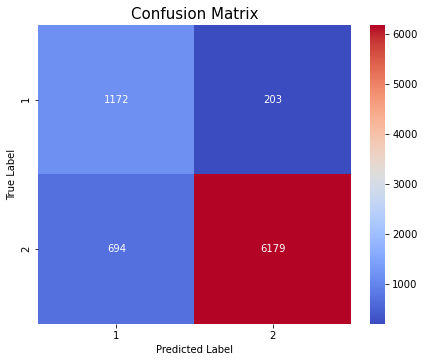

Accuracy: 0.8912
F1-Score: 0.7232


In [27]:
nn_metrics(model, test_padded_sequence, y_test['pn'], 2)

## Additional Layers
Test the effect of additional LSTM layers. I will test with 2, 3 and 4 layers of LSTM.

### Two Layers

In [41]:
embedding_vector_length = 32
opt = tf.keras.optimizers.Adam(learning_rate=0.002)

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(50, dropout=0.5, return_sequences=True))
model.add(LSTM(20, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, scores_cat, validation_split=0.2, 
                    epochs=15, batch_size=32, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/15
619/619 [==============================] - 63s 101ms/step - loss: 0.8103 - accuracy: 0.7640 - val_loss: 0.3691 - val_accuracy: 0.8523
Epoch 2/15
619/619 [==============================] - 62s 100ms/step - loss: 0.6070 - accuracy: 0.8404 - val_loss: 0.2793 - val_accuracy: 0.875170 - accuracy: 0.84
Epoch 3/15
619/619 [==============================] - 61s 99ms/step - loss: 0.5304 - accuracy: 0.8612 - val_loss: 0.3314 - val_accuracy: 0.8626
Epoch 4/15
619/619 [==============================] - 61s 99ms/step - loss: 0.4822 - accuracy: 0.8776 - val_loss: 0.2704 - val_accuracy: 0.8808s:
Epoch 5/15
619/619 [==============================] - 63s 102ms/step - loss: 0.4552 - accuracy: 0.8913 - val_loss: 0.2811 - val_accuracy: 0.8866
Epoch 6/15
619/619 [==============================] - 63s 102ms/step - loss: 0.4215 - accuracy: 0.8934 - val_loss: 0.2731 - val_accuracy: 0.8885
Epoch 7/15
619/619 [==============================] - 63s 102ms/step - loss: 0.3942 - accuracy: 0.9019 - val_lo

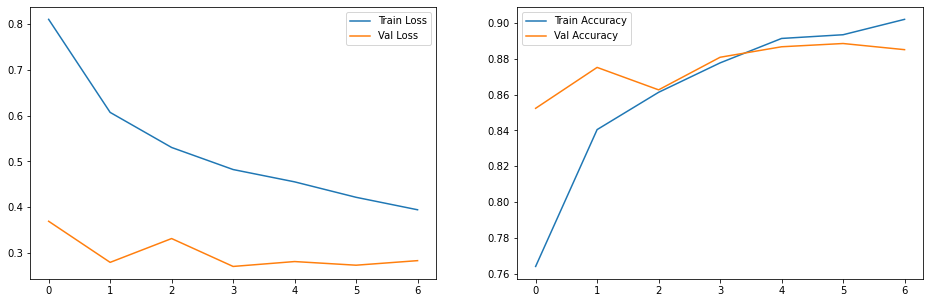

In [42]:
plot_nn_history(history)

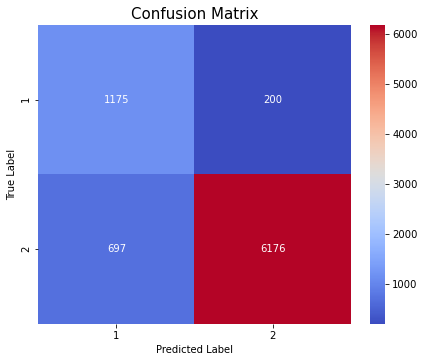

Accuracy: 0.8912
F1-Score: 0.7237


In [43]:
nn_metrics(model, test_padded_sequence, y_test['pn'], 2)

### Three Layer

In [47]:
embedding_vector_length = 32
opt = tf.keras.optimizers.Adam(learning_rate=0.002)

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(50, dropout=0.5, return_sequences=True))
model.add(LSTM(20, dropout=0.5, return_sequences=True))
model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, scores_cat, validation_split=0.2, 
                    epochs=15, batch_size=32, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/15
619/619 [==============================] - 80s 129ms/step - loss: 0.8603 - accuracy: 0.7481 - val_loss: 0.3396 - val_accuracy: 0.8628
Epoch 2/15
619/619 [==============================] - 82s 133ms/step - loss: 0.6725 - accuracy: 0.8254 - val_loss: 0.2968 - val_accuracy: 0.8660
Epoch 3/15
619/619 [==============================] - 77s 124ms/step - loss: 0.5602 - accuracy: 0.8611 - val_loss: 0.3114 - val_accuracy: 0.8600
Epoch 4/15
619/619 [==============================] - 77s 124ms/step - loss: 0.5019 - accuracy: 0.8660 - val_loss: 0.2596 - val_accuracy: 0.8921
Epoch 5/15
619/619 [==============================] - 77s 124ms/step - loss: 0.4698 - accuracy: 0.8869 - val_loss: 0.2734 - val_accuracy: 0.8917
Epoch 6/15
619/619 [==============================] - 77s 124ms/step - loss: 0.4401 - accuracy: 0.8920 - val_loss: 0.2601 - val_accuracy: 0.8927
Epoch 7/15
619/619 [==============================] - 77s 124ms/step - loss: 0.4354 - accuracy: 0.8973 - val_loss: 0.2643 - val_ac

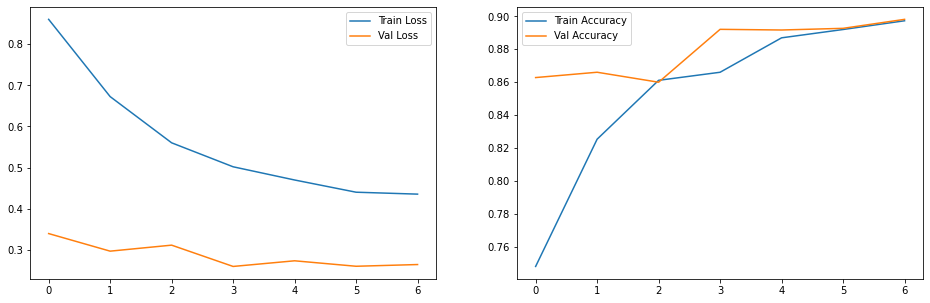

In [48]:
plot_nn_history(history)

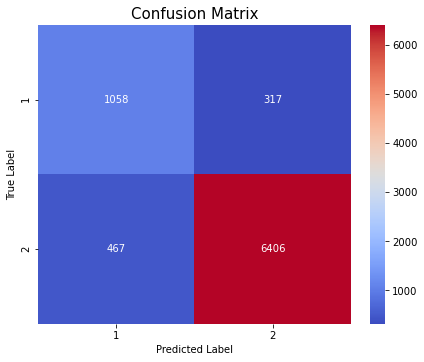

Accuracy: 0.9049
F1-Score: 0.7297


In [49]:
nn_metrics(model, test_padded_sequence, y_test['pn'], 2)

### Four Layers

In [50]:
embedding_vector_length = 32
opt = tf.keras.optimizers.Adam(learning_rate=0.002)

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(50, dropout=0.5, return_sequences=True))
model.add(LSTM(20, dropout=0.5, return_sequences=True))
model.add(LSTM(10, dropout=0.5, return_sequences=True))
model.add(LSTM(5, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

history = model.fit(train_padded_sequence, scores_cat, validation_split=0.2, 
                    epochs=15, batch_size=32, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/15
619/619 [==============================] - 90s 146ms/step - loss: 0.9186 - accuracy: 0.7249 - val_loss: 0.3278 - val_accuracy: 0.8624
Epoch 2/15
619/619 [==============================] - 91s 147ms/step - loss: 0.7066 - accuracy: 0.8148 - val_loss: 0.2936 - val_accuracy: 0.8850
Epoch 3/15
619/619 [==============================] - 90s 146ms/step - loss: 0.6183 - accuracy: 0.8480 - val_loss: 0.3022 - val_accuracy: 0.8870
Epoch 4/15
619/619 [==============================] - 91s 147ms/step - loss: 0.5831 - accuracy: 0.8494 - val_loss: 0.2686 - val_accuracy: 0.8911
Epoch 5/15
619/619 [==============================] - 90s 146ms/step - loss: 0.5498 - accuracy: 0.8677 - val_loss: 0.2925 - val_accuracy: 0.8800
Epoch 6/15
619/619 [==============================] - 91s 146ms/step - loss: 0.5312 - accuracy: 0.8669 - val_loss: 0.2716 - val_accuracy: 0.8939
Epoch 7/15
619/619 [==============================] - 111s 179ms/step - loss: 0.4973 - accuracy: 0.8711 - val_loss: 0.2796 - val_a

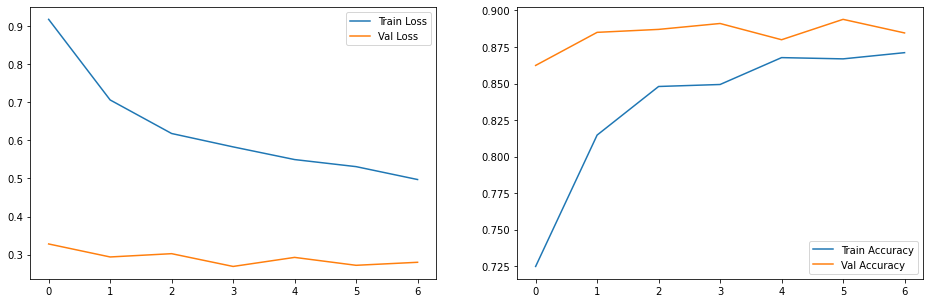

In [51]:
plot_nn_history(history)

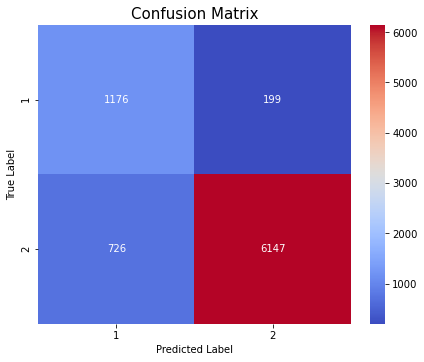

Accuracy: 0.8879
F1-Score: 0.7177


In [52]:
nn_metrics(model, test_padded_sequence, y_test['pn'], 2)

# Final Model

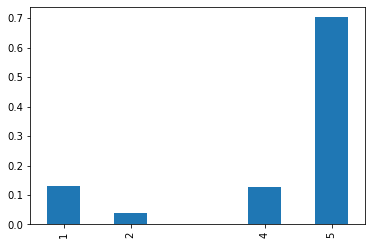

In [53]:
nn_final_df = df[df['score'] != 3].copy()

nn_final_df['score'].value_counts(normalize=True).plot(kind='bar');

In [54]:
def positive_negative(score):
    if score <= 3:
        return 1
    if score > 3:
        return 2
    
nn_final_df['pn'] = nn_final_df['score'].apply(lambda x: positive_negative(x))

nn_final_df['pn'].value_counts(normalize = True)

2    0.83118
1    0.16882
Name: pn, dtype: float64

In [56]:
enc = OneHotEncoder()
scores_cat = enc.fit_transform(nn_final_df[['pn']]).toarray()

classweight = find_class_weight(nn_final_df[['pn']])

In [55]:
vocab_size = 7000

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(nn_final_df['content'].values)

max_len = 125

final_padded_sequence = pad_sequences(tokenizer.texts_to_sequences(nn_final_df['content'].values), maxlen = max_len)

In [61]:
embedding_vector_length = 32
opt = tf.keras.optimizers.Adam(learning_rate=0.002)

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(50, dropout=0.5, return_sequences=True))
model.add(LSTM(20, dropout=0.5, return_sequences=True))
model.add(LSTM(10, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

history = model.fit(final_padded_sequence, scores_cat, validation_split=0.2, shuffle = True,
                    epochs=99, batch_size=128, callbacks=[earlystop_callback], class_weight = classweight)

Epoch 1/99
516/516 [==============================] - 108s 210ms/step - loss: 0.7218 - accuracy: 0.8114 - val_loss: 0.3125 - val_accuracy: 0.8657
Epoch 2/99
516/516 [==============================] - 107s 208ms/step - loss: 0.5502 - accuracy: 0.8589 - val_loss: 0.3061 - val_accuracy: 0.8645
Epoch 3/99
516/516 [==============================] - 107s 207ms/step - loss: 0.4910 - accuracy: 0.8752 - val_loss: 0.2886 - val_accuracy: 0.8826
Epoch 4/99
516/516 [==============================] - 107s 208ms/step - loss: 0.4577 - accuracy: 0.8811 - val_loss: 0.2963 - val_accuracy: 0.8745
Epoch 5/99
516/516 [==============================] - 107s 207ms/step - loss: 0.4435 - accuracy: 0.8856 - val_loss: 0.2719 - val_accuracy: 0.8933
Epoch 6/99
516/516 [==============================] - 107s 207ms/step - loss: 0.4237 - accuracy: 0.8896 - val_loss: 0.2947 - val_accuracy: 0.8786
Epoch 7/99
516/516 [==============================] - 106s 206ms/step - loss: 0.4167 - accuracy: 0.8898 - val_loss: 0.2963 -

# Save Final Model

In [94]:
model.save('models/LSTM_model')

with open('models/LSTM_model_tokenizer.pkl', 'wb') as handle:
    pickle.dump({'tokenizer': tokenizer, 
                 'vocab_size': vocab_size, 
                 'max_len': max_len}, handle)

INFO:tensorflow:Assets written to: models/LSTM_model\assets
